# Song of the Week – Logistic Regression Model Comparison

In this notebooIwe compare three levels of feature complexity for a Logistic Regression model:

1. **Static metadata only** – simple track-level info (e.g. popularity, duration).
2. **Static metadata + genre OHE** – adds high-level "what kind of track is this".
3. **Full engineered features** – weekly behaviour, history, release recency, and genre OHE.

The goal is to understand how much each layer of features improves our ability to predict the weekly favourite, using a **time-based split** and **PR-AUC / ROC-AUC** as main metrics.


### Modeling strategy and evaluation views

The target is `is_week_favorite`, defined at the `(track, week)` level. For each week there is usually a single favourite track, but the dataset contains many candidate tracks per week.

I use two complementary views when training and evaluating models:

1. **Row-level classification view (for tuning)**  
   I treat each `(track, week)` row as a separate example and train models to separate favourites from non-favourites.  
   - Splits are time-based (train / validation / test by week).
   - I use PR-AUC as the primary metric, with ROC-AUC as a secondary check.
   - For Logistic Regression and XGBoost I also tune a decision threshold on the validation split and report precision, recall and F1 on the test split.

2. **Within-week ranking view (for the final decision)**  
   In practice I choose one favourite song per week. To mirror this, I also look at how models rank tracks within each week:
   - For each week I sort tracks by predicted probability.
   - I report Hit@1 (true favourite is ranked #1) and Hit@3 (true favourite is in the top 3).

The workflow in this notebook is:
- Use the row-level classification view and validation PR-AUC to tune Logistic Regression and XGBoost.
- Pick a final Logistic Regression model (`logreg_full_final`) and a simple XGBoost model.
- On the test split, compare them using both:
  - Row-level metrics (PR-AUC, ROC-AUC, threshold-based F1),
  - Week-level ranking metrics (Hit@1 and Hit@3), which align with the real “pick one favourite per week” goal.


In [1]:
from pathlib import Path
import os, sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve, 
    classification_report, 
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split

# move working dir from notebooks/ -> repo root and expose it to Python
repo_root = Path.cwd().parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from common.config_manager import ConfigManager
from common.utils.io import read_csv
from core.features.featurize import (
    get_label_start_dt,
    filter_label_period,
    impute_days_since_release,
    drop_leaky_columns,
    remove_high_corr_features,
    select_feature_columns,
    fit_dv_ohe,
    transform_dv_ohe,
)


In [2]:
# Import ConfigManager, that handles all configurations and file paths
config_manager = ConfigManager(Path.cwd())

# Project config
project_cfg = config_manager.project()

paths = project_cfg["paths"]
processed_dir = Path(paths["core_processed"])
weekly_path = processed_dir / "weekly_table.csv"

# Variables
TARGET_COL = "is_week_favorite"
DATE_COL = "week_saturday_dt"


weekly_path


WindowsPath('core/data/processed/weekly_table.csv')

## Load weekly data and build a clean modeling view

I start from the **weekly table** with Core V1 features and metadata.  
From there, I:

- Filter to the label period (using `modeling.label_start_saturday_utc`).
- Impute `days_since_release`.
- Drop leaky listener/playcount columns.
- Drop a fixed set of highly correlated features.

At this stage I **do not** apply any OHE yet - that will be done later, after splitting.


In [3]:
# Load weekly table with all Core V1 features and metadata
df_weekly = read_csv(weekly_path, safe=True)

# Filter to label period
label_start_dt = get_label_start_dt(project_cfg)
df_model = filter_label_period(df_weekly, label_start_dt)

# Impute days_since_release and add *_was_missing flag
df_model = impute_days_since_release(df_model)

# Drop leaky listener/playcount columns
df_model = drop_leaky_columns(df_model)

# Drop explicitly redundant high-correlation features
df_model = remove_high_corr_features(df_model)

df_model[[DATE_COL, TARGET_COL]].describe(include="all")


,week_saturday_dt,is_week_favorite
count,96112,96112.000000
mean,2023-01-27 12:47:50.351256576+00:00,0.002622
min,2021-01-02 00:00:00+00:00,0.000000
25%,2021-10-09 00:00:00+00:00,0.000000
50%,2022-11-19 00:00:00+00:00,0.000000
75%,2024-04-13 00:00:00+00:00,0.000000
max,2025-11-15 00:00:00+00:00,1.000000
std,NaN,0.051138


## Time-based train / validation / test split

To respect chronology, I split by **week** instead of random rows.

We use a **60 / 20 / 20** split:

- Train: earliest 60% of weeks.
- Validation: next 20%.
- Test: latest 20%.

In [4]:
df_model[DATE_COL] = pd.to_datetime(
    df_model[DATE_COL],
    utc=True,
    errors="coerce",
)

# Sort unique weeks and define cut points for 60 / 20 / 20 splits
weeks = (
    df_model[DATE_COL]
    .sort_values()
    .unique()
)
n_weeks = len(weeks)

train_weeks_end = weeks[int(0.6 * n_weeks)]
val_weeks_end = weeks[int(0.8 * n_weeks)]

train_mask = df_model[DATE_COL] <= train_weeks_end
val_mask = (df_model[DATE_COL] > train_weeks_end) & (df_model[DATE_COL] <= val_weeks_end)
test_mask = df_model[DATE_COL] > val_weeks_end

df_train = df_model.loc[train_mask].reset_index(drop=True)
df_val = df_model.loc[val_mask].reset_index(drop=True)
df_test = df_model.loc[test_mask].reset_index(drop=True)

def _pos_rate(s: pd.Series) -> float:
    return float(s.mean()) if len(s) else float("nan")

print("Rows (train / val / test):", len(df_train), len(df_val), len(df_test))
print(
    "Positive rate (train / val / test): "
    f"{_pos_rate(df_train['is_week_favorite']):.4f} / "
    f"{_pos_rate(df_val['is_week_favorite']):.4f} / "
    f"{_pos_rate(df_test['is_week_favorite']):.4f}"
)


Rows (train / val / test): 66187 15363 14562
Positive rate (train / val / test): 0.0023 / 0.0033 / 0.0034


## One-Hot Encoding for genres (train-only)

For the main experiments, I'll use:

- **Static metadata baselines**: with and without genre OHE.
- **Full engineered model**: weekly behaviour + history + release features + genre OHE.

To avoid leakage:

- Fit the `DictVectorizer` for `genre_bucket` on **train only**.
- Apply the fitted vectorizer to validation and test.


In [5]:
# Fit DictVectorizer-based OHE on train only (genre_bucket)
df_train_ohe, dv_genre, genre_cols = fit_dv_ohe(
    df_train,
    column="genre_bucket",
    min_freq=20,
    prefix="genre",
    keep_original=True,
)

# Apply the same DV to val and test (unseen levels -> all-zero across genre__* columns)
df_val_ohe = transform_dv_ohe(
    df_val,
    dv_genre,
    column="genre_bucket",
    prefix="genre",
    keep_original=True,
)
df_test_ohe = transform_dv_ohe(
    df_test,
    dv_genre,
    column="genre_bucket",
    prefix="genre",
    keep_original=True,
)

# Targets
y_train = df_train_ohe[TARGET_COL].values
y_val = df_val_ohe[TARGET_COL].values
y_test = df_test_ohe[TARGET_COL].values

len(genre_cols), y_train.mean(), y_val.mean(), y_test.mean()


(14, 0.0022965234864852613, 0.0033196641280999807, 0.003364922400769125)

## Evaluation helper

I'll compare models using:

- **ROC-AUC** - how well the model ranks positives above negatives.
- **PR-AUC (Average Precision)** - how good the precision–recall trade-off is, which matters more here given the strong imbalance.


In [6]:
def evaluate_model(name, model, X, y):
    """
    Simple helper to print ROC-AUC and PR-AUC on a given split.
    """
    p = model.predict_proba(X)[:, 1]
    roc = roc_auc_score(y, p)
    pr = average_precision_score(y, p)
    print(f"{name:22s} | ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")


## Baseline 1 – Static metadata only

First, train a Logistic Regression that only sees the original track metadata with positive correlation with is_week_favorite:

- `track_duration`
- `spotify_popularity`


In [7]:
# Original metadata columns
base_cols = [
    "track_duration",
    "spotify_popularity",
]
base_cols = [c for c in base_cols if c in df_train_ohe.columns]

print("Baseline static metadata columns:", base_cols)

if not base_cols:
    raise ValueError("No static metadata columns found for baseline 1.")

X_train_base = df_train_ohe[base_cols].values
X_val_base = df_val_ohe[base_cols].values
X_test_base = df_test_ohe[base_cols].values

logreg_base = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)

logreg_base.fit(X_train_base, y_train)

print("Validation performance – Baseline 1 (static metadata only):")
evaluate_model("logreg_base_static   ", logreg_base, X_val_base, y_val)


Baseline static metadata columns: ['track_duration', 'spotify_popularity']
Validation performance – Baseline 1 (static metadata only):
logreg_base_static     | ROC-AUC: 0.556 | PR-AUC: 0.005


## Baseline 2 – Static metadata + genre OHE

Next, I'll keep the same static metadata and **add genre OHE**:

- `track_duration`
- `spotify_popularity`
- all `genre__*` columns

The OHE was applied on `genre_bucket`column, which was a grouping of the original `spotify_genres` column


In [8]:
# Baseline 2: static metadata + all genre OHE columns
base_cols_static = [c for c in base_cols if c in df_train_ohe.columns]
genre_ohe_cols = [c for c in df_train_ohe.columns if c.startswith("genre__")]

base_cols_static_genre = base_cols_static + genre_ohe_cols

print("Baseline + genre columns (sample):", base_cols_static_genre)
print(f"Total baseline+genre features: {len(base_cols_static_genre)}")


X_train_base_genre = df_train_ohe[base_cols_static_genre].values
X_val_base_genre = df_val_ohe[base_cols_static_genre].values
X_test_base_genre = df_test_ohe[base_cols_static_genre].values

logreg_base_genre = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)

logreg_base_genre.fit(X_train_base_genre, y_train)

print("\nValidation performance – Baseline 2 (static + genre):")
evaluate_model("logreg_base_static   ", logreg_base,       X_val_base,       y_val)
evaluate_model("logreg_base_meta+genre   ", logreg_base_genre, X_val_base_genre, y_val)

Baseline + genre columns (sample): ['track_duration', 'spotify_popularity', 'genre__classical_art', 'genre__electronic_dance', 'genre__experimental_avant', 'genre__folk_country_americana', 'genre__hip_hop_rap', 'genre__jazz', 'genre__latin', 'genre__metal_hard', 'genre__other', 'genre__pop', 'genre__rnb_soul', 'genre__rock', 'genre__unknown', 'genre__world_regional']
Total baseline+genre features: 16

Validation performance – Baseline 2 (static + genre):
logreg_base_static     | ROC-AUC: 0.556 | PR-AUC: 0.005
logreg_base_meta+genre    | ROC-AUC: 0.560 | PR-AUC: 0.004


## Full engineered model – Core V1 features + release + genre OHE

Finally, I'll use the **full feature set**:

- **Static metadata**
  - `track_duration` - length of the track (in seconds), captures typical song length patterns.
  - `spotify_popularity` - Spotify popularity score (0–100), a proxy for how broadly listened the track is overall.
- **Core V1 weekly features**
  - weekly intensity (`scrobbles_week`, `unique_days_week`)
  - end-of-week bias (`scrobbles_last_fri_sat`, `scrobbles_saturday`, `last_scrobble_gap_days`)
  - novelty/history (`first_seen_week`, `prior_scrobbles_all_time`)
  - momentum (`scrobbles_prev_1w`, `scrobbles_prev_4w`, `week_over_week_change`, `momentum_4w_ratio`).
- **Release recency**
  - `days_since_release` and any `released_within_*d` flags, capturing how “new” the track is at that week.
- **Genre OHE**
  - All `genre__*` dummy columns derived from `genre_bucket` (frequent genres kept as separate columns, rare ones collapsed to `other`).


In [9]:
# Use select_feature_columns to get the full engineered feature list
feat_cols_train = select_feature_columns(df_train_ohe)
feat_cols_val = select_feature_columns(df_val_ohe)
feat_cols_test = select_feature_columns(df_test_ohe)

common_feats = sorted(set(feat_cols_train) & set(feat_cols_val) & set(feat_cols_test))

X_train_full = df_train_ohe[common_feats].values
X_val_full = df_val_ohe[common_feats].values
X_test_full = df_test_ohe[common_feats].values

logreg_full = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)

logreg_full.fit(X_train_full, y_train)

print("Validation performance – full vs baselines:")
evaluate_model("logreg_base_static   ", logreg_base,        X_val_base,        y_val)
evaluate_model("logreg_base_meta+g   ", logreg_base_genre,  X_val_base_genre,  y_val)
evaluate_model("logreg_full_plain    ", logreg_full,        X_val_full,        y_val)

Validation performance – full vs baselines:
logreg_base_static     | ROC-AUC: 0.556 | PR-AUC: 0.005
logreg_base_meta+g     | ROC-AUC: 0.560 | PR-AUC: 0.004
logreg_full_plain      | ROC-AUC: 0.983 | PR-AUC: 0.385


## ROC curves – Baselines vs full engineered model

Here I compare the ROC curves of the three models on the **validation** split:

- Baseline 1 – static metadata only
- Baseline 2 – static metadata + genre OHE
- Full model – engineered features + genre OHE

This helps visualize how each model ranks positives vs negatives across all thresholds.


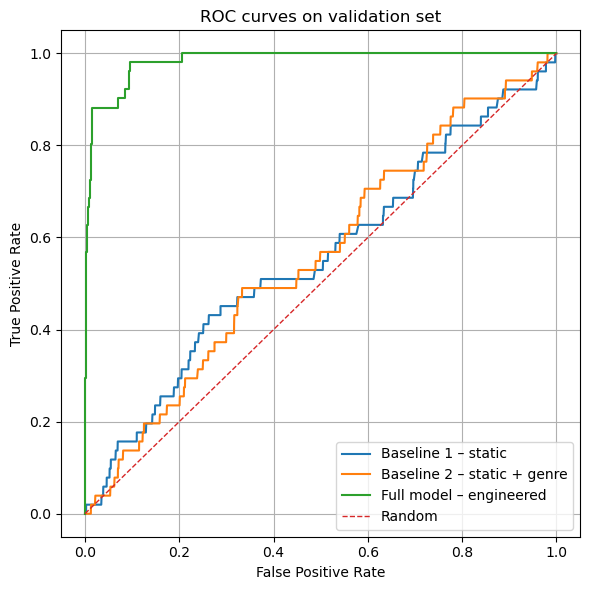

In [10]:
def get_roc_points(model, X, y):
    """Return FPR and TPR arrays for a given model and dataset."""
    p = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, p)
    return fpr, tpr

fpr_base, tpr_base  = get_roc_points(logreg_base, X_val_base, y_val)
fpr_base_genre, tpr_base_genre = get_roc_points(logreg_base_genre, X_val_base_genre, y_val)
fpr_full, tpr_full = get_roc_points(logreg_full, X_val_full, y_val)

plt.figure(figsize=(6, 6))

plt.plot(fpr_base, tpr_base, label="Baseline 1 – static")
plt.plot(fpr_base_genre, tpr_base_genre, label="Baseline 2 – static + genre")
plt.plot(fpr_full, tpr_full, label="Full model – engineered")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves on validation set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Parameter Tuning 



The Logistic Regression model has two man iparameter” we care about:

1. **Regularization strength (C)** – controls how complex the model is for a fixed feature set.
2. **Decision threshold** – turns predicted probabilities into a hard “favorite / not favorite” labeI'll

We tune them in two stages:

irst, we fix the feature set and search over a small grid of **C values**, using **validation ROC-AUC and PR-AUC** to pick a good regularization level.
- Then, withfixed  we tune the **probability threshold** on the validation set by looking at the **F1 score** across th threshold.


## C Tuning

To keep things simple, we tune only **C** (inverse regularization strength) for the full-feature Logistic Regression.

We train the model for a small set of C values and look at:

- ROC-AUC on validation
- PR-AUC on validation

This gives a quick sense of where the model performs best without an exhaustive search.


In [11]:
# Grid of C values to try (log scale)
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

tuning_results = []

for C in C_values:
    model = LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        random_state=42,
        C=C,
    )
    model.fit(X_train_full, y_train)

    p_val = model.predict_proba(X_val_full)[:, 1]
    roc = roc_auc_score(y_val, p_val)
    pr = average_precision_score(y_val, p_val)

    tuning_results.append({"C": C, "roc_auc": roc, "pr_auc": pr})

tuning_df = pd.DataFrame(tuning_results)
tuning_df


,C,roc_auc,pr_auc
0,0.01,0.983313,0.397512
1,0.10,0.984167,0.398140
2,1.00,0.983419,0.384976
3,10.00,0.983433,0.385489
4,100.00,0.983669,0.379602


### Visualizing C vs ROC-AUC / PR-AUC

The plot below shows how ROC-AUC and PR-AUC change as we vary **C**.  
We use a log scale on the x-axis.


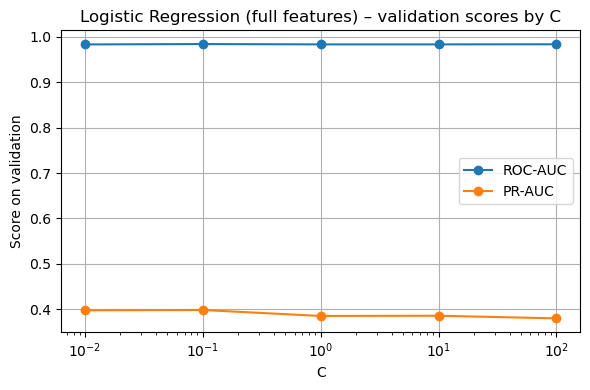

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(tuning_df["C"], tuning_df["roc_auc"], marker="o", label="ROC-AUC")
ax.plot(tuning_df["C"], tuning_df["pr_auc"],  marker="o", label="PR-AUC")

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Score on validation")
ax.set_title("Logistic Regression (full features) – validation scores by C")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


### Decision - C

We'll use `C=0.01` since it provides the best PR_AUC value (which is the primary metric due to class imbalance)

In [13]:
best_C = 0.01

## Threshold tuning

The model outputs probabilities, not hard labels.

To turn scores into "favorite / not favorite", we choose a probability threshold.
Here we:
- train a Logistic Regression with **C = 0.01** on the **train** split,
- sweep thresholds on the **validation** split using the precision–recall curve,
- pick the threshold that maximizes **F1**,
- and later apply this threshold to the final train+val model on the test set.


Best threshold on validation (max F1): 0.2358
  Precision: 0.478
  Recall   : 0.431
  F1       : 0.454


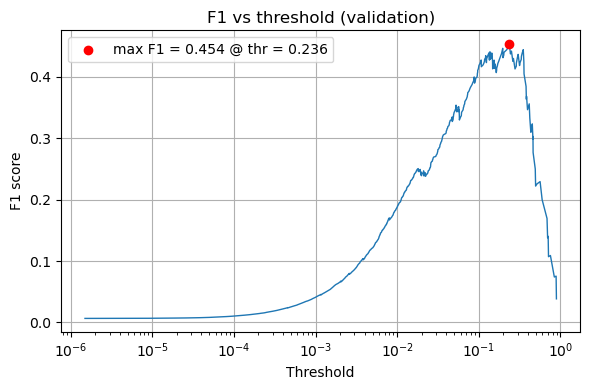

In [14]:
# Model trained only on train for threshold selection
logreg_for_threshold = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
    C=best_C,
)
logreg_for_threshold.fit(X_train_full, y_train)

# Validation scores
p_val = logreg_for_threshold.predict_proba(X_val_full)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# Compute F1 for each candidate threshold (skip the last precision/recall point)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold on validation (max F1): {best_threshold:.4f}")
print(f"  Precision: {precision[best_idx]:.3f}")
print(f"  Recall   : {recall[best_idx]:.3f}")
print(f"  F1       : {f1_scores[best_idx]:.3f}")

# Plot F1 vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, linewidth=1)
plt.scatter(
    thresholds[best_idx],
    f1_scores[best_idx],
    color="red",
    zorder=3,
    label=f"max F1 = {f1_scores[best_idx]:.3f} @ thr = {best_threshold:.3f}",
)

plt.xscale("log")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 vs threshold (validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Decision - Threshold

We'll use `threshold=0.152` since it provides the best F1 value

In [15]:
best_threshold=0.152

## Final Logistic Regression model - train + validation, then test evaluation

We now fix the final configuration:

- Logistic Regression with the **full engineered feature set**

We retrain this model on **train + validation** and then evaluate it **once** on the held-out test set.


In [16]:
# Stack train and validation for the final fit
X_trainval_full = np.vstack([X_train_full, X_val_full])
y_trainval = np.concatenate([y_train, y_val])

logreg_full_final = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
    C=best_C,
)

logreg_full_final.fit(X_trainval_full, y_trainval)

print("Final model configuration:")
print(f"  Features: full engineered set ({X_train_full.shape[1]} features)")
print(f"  C: {best_C}")

print("\nTest performance – final model (train+val → test):")
evaluate_model("logreg_full_final", logreg_full_final, X_test_full, y_test)

Final model configuration:
  Features: full engineered set (30 features)
  C: 0.01

Test performance – final model (train+val → test):
logreg_full_final      | ROC-AUC: 0.985 | PR-AUC: 0.257


## Final classification metrics on test (using tuned threshold)

With the final model (trained on train + validation, C = 0.01) and the
threshold tuned on the validation set, we now evaluate on the held-out test
set and report:

- Precision
- Recall
- F1 score
- Confusion matrix


In [17]:
# Probabilities from the final train+val model on the test split
p_test = logreg_full_final.predict_proba(X_test_full)[:, 1]

# Apply tuned threshold from validation
y_test_pred = (p_test >= best_threshold).astype(int)

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Threshold used: {best_threshold:.4f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}\n")

print("Classification report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

print("Confusion matrix (test):")
print(cm)

Threshold used: 0.1520
Precision: 0.304
Recall:    0.490
F1 score:  0.375

Classification report (test):
              precision    recall  f1-score   support

           0      0.998     0.996     0.997     14513
           1      0.304     0.490     0.375        49

    accuracy                          0.995     14562
   macro avg      0.651     0.743     0.686     14562
weighted avg      0.996     0.995     0.995     14562

Confusion matrix (test):
[[14458    55]
 [   25    24]]


## XGBoost model

In this section I train and tun an XGBoost model on the same features and time base-dased train/validation/test splits used for the Logistic Regression baseline.

I start with a simple XGBoost baseline, then:

1. Run a wider sweep over `max_depth` and `n_estimators` to understand how model capacity affects performance.
2. Take the most promising capacity settings and run a second, more detailed sweep over learning rate and regularization/sampling parameters.

The goal is to find a configuration that improves validation PR-AUC compared to Logistic Regression without going completely overboard on complexity.

### 1. Imports and class balance

First I import `XGBClassifier` and check the class balance on the training set.  
This will be used to set `scale_pos_weight` so XGBoost pays more attention to the positive class.


In [18]:
from xgboost import XGBClassifier
random_state = 42
n_jobs = -1

# Class balance on the train split
n_pos_train = int(y_train.sum())
n_neg_train = int(len(y_train) - n_pos_train)
pos_rate_train = n_pos_train / (n_pos_train + n_neg_train)

# Heuristic for imbalanced data: weight negatives vs positives
scale_pos_weight = n_neg_train / n_pos_train

print(f"Train positives: {n_pos_train}")
print(f"Train negatives: {n_neg_train}")
print(f"Positive rate (train): {pos_rate_train:.6f}")
print(f"scale_pos_weight: {scale_pos_weight:.1f}")


Train positives: 152
Train negatives: 66035
Positive rate (train): 0.002297
scale_pos_weight: 434.4


### 2. XGBoost baseline

Here I train a first XGBoost model on the same feature matrix used for the full Logistic Regression model (`X_train_full`, `X_val_full`).

For this baseline I only change a few key things:

- `scale_pos_weight` to account for the class imbalance (computed from the train split).
- `n_estimators` and `learning_rate` as a simple starting point.
- `random_state` and `n_jobs` for reproducibility and speed.

All other parameters stay at their XGBoost defaults. The goal is to get a basic tree-based model running, and then tune it step by step.


In [19]:
xgb_baseline = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    random_state=random_state,
    n_jobs=n_jobs,
)

xgb_baseline.fit(X_train_full, y_train)

print("Validation performance – XGBoost baseline:")
evaluate_model("xgb_baseline_val", xgb_baseline, X_val_full, y_val)

Validation performance – XGBoost baseline:
xgb_baseline_val       | ROC-AUC: 0.935 | PR-AUC: 0.382


### 3. XGBoost tuning – capacity (max_depth, n_estimators)

In the first tuning step I keep `learning_rate` and `scale_pos_weight` fixed and vary the main capacity knobs:

- `max_depth`: how complex each tree can be.
- `n_estimators`: how many trees are used.

I train each configuration on the train split and evaluate on the validation split using the same `evaluate_model` helper.  
The goal is to find a reasonable depth / number-of-trees combination that gives good validation PR-AUC without overfitting.

In [20]:
from collections import OrderedDict
import itertools

def run_xgb_sweep(
    name_prefix,
    base_params,
    grid_params,
    X_train,
    y_train,
    X_val,
    y_val,
):
    """
    Run an XGBoost hyperparameter sweep and return a DataFrame
    with ROC-AUC and PR-AUC on the validation split.
    """
    results = []

    grid_keys = list(grid_params.keys())
    grid_values = [grid_params[k] for k in grid_keys]

    for values in itertools.product(*grid_values):
        params = dict(base_params)
        suffix_parts = []

        for key, value in zip(grid_keys, values):
            params[key] = value
            suffix_parts.append(f"{key}{value}")

        model_name = f"{name_prefix}_" + "_".join(suffix_parts)

        xgb_model = XGBClassifier(**params)
        xgb_model.fit(X_train, y_train)

        # Log metrics using the existing helper
        evaluate_model(model_name, xgb_model, X_val, y_val)

        # Compute metrics explicitly for the results table
        y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_val_proba)
        pr_auc = average_precision_score(y_val, y_val_proba)

        result = OrderedDict(
            model_name=model_name,
            roc_auc_val=roc_auc,
            pr_auc_val=pr_auc,
        )
        for k in grid_keys:
            result[k] = params[k]

        results.append(result)

    results_df = (
        pd.DataFrame(results)
        .sort_values("pr_auc_val", ascending=False)
        .reset_index(drop=True)
    )

    return results_df

In [21]:

# Sweep over capacity: max_depth and n_estimators
base_params_cap = dict(
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=random_state,
    n_jobs=n_jobs,
)

grid_cap = {
    "max_depth": [3, 4, 5, 6, 7],
    "n_estimators": [100, 200, 400, 800, 1500],
}

xgb_sweep_results_cap = run_xgb_sweep(
    name_prefix="xgb_cap",
    base_params=base_params_cap,
    grid_params=grid_cap,
    X_train=X_train_full,
    y_train=y_train,
    X_val=X_val_full,
    y_val=y_val,
)

xgb_sweep_results_cap.head(10)


xgb_cap_max_depth3_n_estimators100 | ROC-AUC: 0.964 | PR-AUC: 0.375
xgb_cap_max_depth3_n_estimators200 | ROC-AUC: 0.955 | PR-AUC: 0.339
xgb_cap_max_depth3_n_estimators400 | ROC-AUC: 0.946 | PR-AUC: 0.314
xgb_cap_max_depth3_n_estimators800 | ROC-AUC: 0.928 | PR-AUC: 0.329
xgb_cap_max_depth3_n_estimators1500 | ROC-AUC: 0.917 | PR-AUC: 0.316
xgb_cap_max_depth4_n_estimators100 | ROC-AUC: 0.969 | PR-AUC: 0.379
xgb_cap_max_depth4_n_estimators200 | ROC-AUC: 0.958 | PR-AUC: 0.349
xgb_cap_max_depth4_n_estimators400 | ROC-AUC: 0.937 | PR-AUC: 0.377
xgb_cap_max_depth4_n_estimators800 | ROC-AUC: 0.923 | PR-AUC: 0.388
xgb_cap_max_depth4_n_estimators1500 | ROC-AUC: 0.911 | PR-AUC: 0.394
xgb_cap_max_depth5_n_estimators100 | ROC-AUC: 0.964 | PR-AUC: 0.355
xgb_cap_max_depth5_n_estimators200 | ROC-AUC: 0.947 | PR-AUC: 0.375
xgb_cap_max_depth5_n_estimators400 | ROC-AUC: 0.926 | PR-AUC: 0.386
xgb_cap_max_depth5_n_estimators800 | ROC-AUC: 0.916 | PR-AUC: 0.384
xgb_cap_max_depth5_n_estimators1500 | ROC-AUC:

,model_name,roc_auc_val,pr_auc_val,max_depth,n_estimators
0,xgb_cap_max_depth7_n_estimators800,0.929182,0.428755,7,800
1,xgb_cap_max_depth7_n_estimators1500,0.924523,0.426913,7,1500
2,xgb_cap_max_depth7_n_estimators400,0.932949,0.424777,7,400
3,xgb_cap_max_depth7_n_estimators200,0.943941,0.422544,7,200
4,xgb_cap_max_depth7_n_estimators100,0.959841,0.411553,7,100
5,xgb_cap_max_depth6_n_estimators800,0.920302,0.397066,6,800
6,xgb_cap_max_depth6_n_estimators400,0.928315,0.395358,6,400
7,xgb_cap_max_depth4_n_estimators1500,0.910693,0.394353,4,1500
8,xgb_cap_max_depth6_n_estimators1500,0.915463,0.391107,6,1500
9,xgb_cap_max_depth5_n_estimators1500,0.909871,0.389035,5,1500


### 4. XGBoost tuning – learning rate and sampling

From the capacity sweep I saw that two capacity settings looked especially strong:

- A larger model: deeper trees with more boosting rounds
- A smaller model: shallower trees with fewer trees, but still strong performance

To keep things simple, I pick one configuration from each family and treat them as two "base" setups:

- A high-capacity model (depth 7, 1500 trees)
- A more regularized model (depth 4, 400 trees)

In this step I keep each base capacity fixed and tune:

- `learning_rate`
- `min_child_weight`
- `subsample`
- `colsample_bytree`

The idea is to:

1. Let the high-capacity model try to squeeze out as much PR-AUC as possible.
2. Let the smaller model show how far it can go with stronger regularization and sampling.

After this, I will compare both families side by side and pick final candidates for evaluation on the test set.

In [22]:
# Second sweep: refine two base capacity configs

base_capacity_configs = [
    dict(name="xgb_md7_ne1500", max_depth=7, n_estimators=1500),
    dict(name="xgb_md4_ne400", max_depth=4, n_estimators=400),
]

grid_stage2 = {
    "learning_rate": [0.03, 0.05, 0.1],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

all_stage2_results = []

for cfg in base_capacity_configs:
    print(f"\n=== Stage 2 sweep for {cfg['name']} ===")

    base_params_stage2 = dict(
        max_depth=cfg["max_depth"],
        n_estimators=cfg["n_estimators"],
        scale_pos_weight=scale_pos_weight,
        random_state=random_state,
        n_jobs=n_jobs,
    )

    res = run_xgb_sweep(
        name_prefix=cfg["name"],
        base_params=base_params_stage2,
        grid_params=grid_stage2,
        X_train=X_train_full,
        y_train=y_train,
        X_val=X_val_full,
        y_val=y_val,
    )
    res["base_config"] = cfg["name"]
    all_stage2_results.append(res)

xgb_sweep_results_stage2 = (
    pd.concat(all_stage2_results, ignore_index=True)
    .sort_values("pr_auc_val", ascending=False)
    .reset_index(drop=True)
)



=== Stage 2 sweep for xgb_md7_ne1500 ===
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample0.6_colsample_bytree0.6 | ROC-AUC: 0.933 | PR-AUC: 0.404
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample0.6_colsample_bytree0.8 | ROC-AUC: 0.935 | PR-AUC: 0.381
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample0.6_colsample_bytree1.0 | ROC-AUC: 0.934 | PR-AUC: 0.388
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample0.8_colsample_bytree0.6 | ROC-AUC: 0.942 | PR-AUC: 0.423
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample0.8_colsample_bytree0.8 | ROC-AUC: 0.933 | PR-AUC: 0.392
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample0.8_colsample_bytree1.0 | ROC-AUC: 0.930 | PR-AUC: 0.398
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample1.0_colsample_bytree0.6 | ROC-AUC: 0.940 | PR-AUC: 0.413
xgb_md7_ne1500_learning_rate0.03_min_child_weight1_subsample1.0_colsample_bytree0.8 | ROC-AUC: 0.938 | PR-AUC: 0.422
xgb_md7_ne1500_learnin

In [23]:
# Top 10 Results - Overall
xgb_sweep_results_stage2.head(10)

,model_name,roc_auc_val,pr_auc_val,learning_rate,min_child_weight,subsample,colsample_bytree,base_config
0,xgb_md7_ne1500_learning_rate0.03_min_child_wei...,0.931532,0.461786,0.03,5,1.0,0.6,xgb_md7_ne1500
1,xgb_md4_ne400_learning_rate0.1_min_child_weigh...,0.933690,0.451279,0.10,5,0.6,0.6,xgb_md4_ne400
2,xgb_md7_ne1500_learning_rate0.03_min_child_wei...,0.923865,0.446873,0.03,3,1.0,0.8,xgb_md7_ne1500
3,xgb_md7_ne1500_learning_rate0.05_min_child_wei...,0.917760,0.446421,0.05,5,1.0,0.6,xgb_md7_ne1500
4,xgb_md7_ne1500_learning_rate0.03_min_child_wei...,0.918486,0.446210,0.03,3,1.0,1.0,xgb_md7_ne1500
5,xgb_md7_ne1500_learning_rate0.1_min_child_weig...,0.913406,0.445013,0.10,1,1.0,0.8,xgb_md7_ne1500
6,xgb_md7_ne1500_learning_rate0.03_min_child_wei...,0.934579,0.443764,0.03,3,1.0,0.6,xgb_md7_ne1500
7,xgb_md7_ne1500_learning_rate0.03_min_child_wei...,0.928466,0.440966,0.03,5,0.8,0.6,xgb_md7_ne1500
8,xgb_md7_ne1500_learning_rate0.03_min_child_wei...,0.931636,0.440064,0.03,1,1.0,1.0,xgb_md7_ne1500
9,xgb_md7_ne1500_learning_rate0.05_min_child_wei...,0.925275,0.437362,0.05,1,1.0,1.0,xgb_md7_ne1500


In [24]:
# Deep Params
best_deep_params = dict(
    max_depth=7,
    n_estimators=1500,
    learning_rate=0.05,
    min_child_weight=5,
    subsample=1.0,
    colsample_bytree=1.0,
)

# Simple params
best_simple_params = dict(
    max_depth=4,
    n_estimators=400,
    learning_rate=0.1,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.6,
)

In [35]:
# Build train+val set for final fits
X_trainval_full = np.vstack([X_train_full, X_val_full])
y_trainval = np.concatenate([y_train, y_val])


# Deep candidate
xgb_deep = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=random_state,
    n_jobs=n_jobs,
    **best_deep_params,
)

xgb_deep.fit(X_trainval_full, y_trainval)
print("Test performance – XGBoost deep candidate:")
evaluate_model("xgb_deep_test", xgb_deep, X_test_full, y_test)

# Simpler candidate
xgb_simple = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=random_state,
    n_jobs=n_jobs,
    **best_simple_params,
)

xgb_simple.fit(X_trainval_full, y_trainval)
print("\nTest performance – XGBoost simple candidate:")
evaluate_model("xgb_simple_test", xgb_simple, X_test_full, y_test)


Test performance – XGBoost deep candidate:
xgb_deep_test          | ROC-AUC: 0.968 | PR-AUC: 0.227

Test performance – XGBoost simple candidate:
xgb_simple_test        | ROC-AUC: 0.970 | PR-AUC: 0.259


## Decision

The *simple model* seems to perform better on test, and crucially, is much more simple and quick to run. I'll continue with that one.

In [26]:
xgb_params = best_simple_params

In [34]:
xgb_for_threshold = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=random_state,
    n_jobs=n_jobs,
    **xgb_params,
)

xgb_for_threshold.fit(X_train_full, y_train)

# Validation scores for XGBoost
p_val_xgb = xgb_for_threshold.predict_proba(X_val_full)[:, 1]

precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_val, p_val_xgb)

# Compute F1 for each candidate threshold
f1_scores_xgb = 2 * precision_xgb[:-1] * recall_xgb[:-1] / (
    precision_xgb[:-1] + recall_xgb[:-1] + 1e-8
)

best_idx_xgb = np.argmax(f1_scores_xgb)
best_threshold_xgb = thresholds_xgb[best_idx_xgb]

print(f"Best XGBoost threshold on validation: {best_threshold_xgb:.4f}")
print(f"Max F1 (val) for XGBoost: {f1_scores_xgb[best_idx_xgb]:.3f}")

# Train final simple XGBoost on train + val and evaluate on test
X_trainval_full = np.vstack([X_train_full, X_val_full])
y_trainval = np.concatenate([y_train, y_val])

xgb_final = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=random_state,
    n_jobs=n_jobs,
    **xgb_params,
)

xgb_final.fit(X_trainval_full, y_trainval)

# Probabilities and threshold-based predictions on test
p_test_xgb = xgb_final.predict_proba(X_test_full)[:, 1]
y_test_pred_xgb = (p_test_xgb >= best_threshold_xgb).astype(int)

precision_test_xgb = precision_score(y_test, y_test_pred_xgb)
recall_test_xgb = recall_score(y_test, y_test_pred_xgb)
f1_test_xgb = f1_score(y_test, y_test_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print("\nXGBoost model – test metrics with tuned threshold:")
print(f"Threshold used (XGB): {best_threshold_xgb:.4f}")
print(f"Precision: {precision_test_xgb:.3f}")
print(f"Recall:    {recall_test_xgb:.3f}")
print(f"F1 score:  {f1_test_xgb:.3f}\n")

print("Classification report (XGB, test):")
print(classification_report(y_test, y_test_pred_xgb, digits=3))

print("Confusion matrix (XGB, test):")
print(cm_xgb)


Best XGBoost threshold on validation: 0.9793
Max F1 (val) for XGBoost: 0.456

XGBoost model – test metrics with tuned threshold:
Threshold used (XGB): 0.9793
Precision: 0.355
Recall:    0.224
F1 score:  0.275

Classification report (XGB, test):
              precision    recall  f1-score   support

           0      0.997     0.999     0.998     14513
           1      0.355     0.224     0.275        49

    accuracy                          0.996     14562
   macro avg      0.676     0.612     0.637     14562
weighted avg      0.995     0.996     0.996     14562

Confusion matrix (XGB, test):
[[14493    20]
 [   38    11]]


## Final comparison - week-level ranking (LogReg vs XGBoost)

Beyond row-level metrics, the real goal is to pick one favourite track per week.

In this section I compare the final Logistic Regression model (`logreg_full_final`) and the final simple XGBoost model (`xgb_simple_final`) using a week-level ranking view:

- For each week in the test split, I take all candidate tracks and sort them by model probability.
- I compute:
  - Hit@1: fraction of weeks where the true favourite is ranked #1.
  - Hit@3: fraction of weeks where the true favourite appears in the top 3.

These ranking metrics are closer to the real use case than a global threshold, so they are the main criteria to decide which model I would use to suggest the weekly favourite.


In [28]:
def compute_week_ranking_metrics(
    df,
    prob_col,
    label_col=TARGET_COL,
    week_col=DATE_COL,
    top_k=3,
):
    """
    Compute simple week-level ranking metrics:
    - Hit@1: fraction of weeks where the favourite is ranked #1.
    - Hit@K: fraction of weeks where the favourite is in the top K.

    Only weeks that have at least one positive label are counted.
    """
    hit_at_1 = 0
    hit_at_k = 0
    n_weeks = 0

    for week_value, grp in df.groupby(week_col):
        # Skip weeks with no labelled favourite (just in case)
        if grp[label_col].sum() == 0:
            continue

        n_weeks += 1
        grp_sorted = grp.sort_values(prob_col, ascending=False)

        labels = grp_sorted[label_col].values

        # Hit@1: favourite is at rank 1
        if labels[0] == 1:
            hit_at_1 += 1

        # Hit@K: favourite appears in the top K
        if labels[:top_k].sum() > 0:
            hit_at_k += 1

    if n_weeks == 0:
        return {
            "n_weeks": 0,
            "hit_at_1": 0.0,
            f"hit_at_{top_k}": 0.0,
        }

    return {
        "n_weeks": n_weeks,
        "hit_at_1": hit_at_1 / n_weeks,
        f"hit_at_{top_k}": hit_at_k / n_weeks,
    }


In [33]:
# Probabilities on test for both models
p_test_lr = logreg_full_final.predict_proba(X_test_full)[:, 1]
p_test_xgb = xgb_final.predict_proba(X_test_full)[:, 1]

# Attach probabilities to df_test
df_test_lr = df_test.copy()
df_test_lr["p_lr"] = p_test_lr

df_test_xgb = df_test.copy()
df_test_xgb["p_xgb"] = p_test_xgb

metrics_lr = compute_week_ranking_metrics(
    df=df_test_lr,
    prob_col="p_lr",
    label_col=TARGET_COL,
    week_col=DATE_COL,
    top_k=3,
)

metrics_xgb = compute_week_ranking_metrics(
    df=df_test_xgb,
    prob_col="p_xgb",
    label_col=TARGET_COL,
    week_col=DATE_COL,
    top_k=3,
)

print("Logistic Regression – week-level ranking metrics:")
print(metrics_lr)

print("\nXGBoost (simple) – week-level ranking metrics:")
print(metrics_xgb)


Logistic Regression – week-level ranking metrics:
{'n_weeks': 49, 'hit_at_1': 0.3673469387755102, 'hit_at_3': 0.673469387755102}

XGBoost (simple) – week-level ranking metrics:
{'n_weeks': 49, 'hit_at_1': 0.32653061224489793, 'hit_at_3': 0.6530612244897959}


In [30]:
top_k = 5

def build_topk_table(df, prob_col, k=5):
    # Sort by week + probability desc
    df_sorted = df.sort_values([DATE_COL, prob_col], ascending=[True, False]).copy()

    # Rank within each week by probability
    df_sorted["rank"] = (
        df_sorted.groupby(DATE_COL)[prob_col]
        .rank(method="first", ascending=False)
        .astype(int)
    )

    # Keep only top-k per week
    df_topk = df_sorted[df_sorted["rank"] <= k].copy()

    # Mark the true favourite
    df_topk["is_true_favorite"] = np.where(df_topk[TARGET_COL] == 1, "Yes", "")

    # Order columns for readability
    cols = [
        DATE_COL,
        "rank",
        "artist_name",
        "track_name",
        prob_col,
        "is_true_favorite",
    ]

    return df_topk[cols].sort_values([DATE_COL, "rank"])


In [31]:
top5_lr = build_topk_table(df_test_lr, prob_col="p_lr", k=top_k)
top5_xgb = build_topk_table(df_test_xgb, prob_col="p_xgb", k=top_k)

print("Top-5 per week – Logistic Regression:")
top5_lr.head(50)


Top-5 per week – Logistic Regression:


,week_saturday_dt,rank,artist_name,track_name,p_lr,is_true_favorite
11386,2024-12-07 00:00:00+00:00,1,Samuel Úria,Era de ouro,0.415402,
9738,2024-12-07 00:00:00+00:00,2,Natalia Lafourcade,Sembrando Flores,0.121296,
11280,2024-12-07 00:00:00+00:00,3,Samuel Úria,2000 A.D.,0.071899,
10060,2024-12-07 00:00:00+00:00,4,O Terno,Volta e Meia,0.019644,Yes
11545,2024-12-07 00:00:00+00:00,5,Samuel Úria,Xico da Ladra,0.017198,
9344,2024-12-14 00:00:00+00:00,1,Milhanas,Algo Mais,0.652507,Yes
9843,2024-12-14 00:00:00+00:00,2,Nilüfer Yanya,Like I Say (I Runaway),0.148920,
9818,2024-12-14 00:00:00+00:00,3,Nilüfer Yanya,Faith’s Late,0.050467,
7385,2024-12-14 00:00:00+00:00,4,King Gizzard & The Lizard Wizard,Le Risque,0.044399,
2491,2024-12-14 00:00:00+00:00,5,Charli xcx,pink diamond,0.037147,


In [32]:

print("\nTop-5 per week – XGBoost (simple):")
top5_xgb[49:100]


Top-5 per week – XGBoost (simple):


,week_saturday_dt,rank,artist_name,track_name,p_xgb,is_true_favorite
13290,2025-02-08 00:00:00+00:00,5,The Weeknd,São Paulo (feat. Anitta),0.769829,
286,2025-02-15 00:00:00+00:00,1,Air,New Star in the Sky (Chanson pour Solal),0.947602,
278,2025-02-15 00:00:00+00:00,2,Air,Le Voyage de Pénélope,0.822461,
4485,2025-02-15 00:00:00+00:00,3,Geordie Greep,Terra,0.642116,
245,2025-02-15 00:00:00+00:00,4,Air,Ce Matin-là,0.224147,
321,2025-02-15 00:00:00+00:00,5,Air,Talisman,0.114218,
571,2025-02-22 00:00:00+00:00,1,Ana Frango Elétrico,Dela,0.973492,
5423,2025-02-22 00:00:00+00:00,2,Ichiko Aoba,月の丘,0.539047,Yes
11735,2025-02-22 00:00:00+00:00,3,Sigur Rós,Glóð,0.384891,
11652,2025-02-22 00:00:00+00:00,4,Sigur Rós,Blóðberg,0.377061,


## Final model choice and interpretation

Results:

- **Logistic Regression**
  - Higher Hit@1 (better when the model makes a single, automatic choice per week).
  - Strong PR-AUC and good overall separation between favourites and non-favourites.

- **XGBoost (simple)**
  - Slightly better Hit@3 and stronger global PR-AUC.
  - Better if the goal was to suggest a short list of candidates per week rather than a single pick.

The main goal of this project is for the model to pick **one weekly favourite track**.  
Because of that, I prioritise Hit@1 and choose **Logistic Regression** as the final model:

- It is simpler and easier to interpret.
- It has competitive PR-AUC.
- It correctly ranks the true favourite at the top more often than the XGBoost model.

The tuned XGBoost model could instead be used more like a recommender (e.g. suggest a top-3 shortlist for each week)
